In [18]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import logging
from model.models import Simulator
import service.regressor as regressor
import pickle
import service.files_service as fs
import csv


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_t = pd.read_csv('data/merged_no_spread_light.csv',sep=';')

In [3]:
cols = [col for col in df_t.columns.tolist() if (('Unnamed' not in col or 'USD' not in col) and( 'Open_Ask'  in col  or 'cal' in col))]
df_t2 = df_t[cols]
print len(df_t2.columns)
df_t2.to_csv('data/merged_no_spread_ultralight.csv',sep=';')

21


In [4]:
df_t2.cal_time = pd.to_datetime(df_t2.cal_time, infer_datetime_format=True)
df_t2[df_t2.cal_time<'2011-09-29 10:00']

/home/ramon/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,cal_time,Open_Ask_EURRUB,Open_Ask_USDRUB,Open_Ask_USDCAD,Open_Ask_LIGHTCMDUSD,Open_Ask_USDMXN,Open_Ask_EURNOK,Open_Ask_USDNOK,Open_Ask_BRENTCMDUSD,cal_hour,...,cal_dayofweek,cal_dayofyear,Open_Ask_EURRUB_reg,Open_Ask_USDRUB_reg,Open_Ask_USDCAD_reg,Open_Ask_LIGHTCMDUSD_reg,Open_Ask_USDMXN_reg,Open_Ask_EURNOK_reg,Open_Ask_USDNOK_reg,Open_Ask_BRENTCMDUSD_reg
0,2011-09-23 07:09:00,43.37191,32.11331,1.02590,80.660,13.90060,7.84335,5.80184,105.781,7,...,4,266,-0.747274,-0.815173,-0.843176,0.181000,-0.328009,-0.689701,-0.891706,0.689287
1,2011-09-23 07:10:00,43.36161,32.12177,1.02584,80.710,13.91499,7.84255,5.80290,105.783,7,...,4,266,-0.747980,-0.814637,-0.843625,0.183010,-0.321508,-0.690812,-0.890772,0.689355
2,2011-09-23 07:11:00,43.36351,32.11577,1.02585,80.690,13.91620,7.84402,5.80302,105.795,7,...,4,266,-0.747850,-0.815017,-0.843550,0.182206,-0.320962,-0.688770,-0.890666,0.689762
3,2011-09-23 07:12:00,43.39175,32.11914,1.02594,80.640,13.91313,7.84386,5.80362,105.723,7,...,4,266,-0.745915,-0.814804,-0.842877,0.180197,-0.322348,-0.688992,-0.890138,0.687318
4,2011-09-23 07:13:00,43.37011,32.12046,1.02588,80.700,13.92211,7.84445,5.80328,105.734,7,...,4,266,-0.747398,-0.814720,-0.843326,0.182608,-0.318292,-0.688173,-0.890437,0.687692
5,2011-09-23 07:14:00,43.36714,32.13019,1.02574,80.680,13.92290,7.84573,5.80457,105.704,7,...,4,266,-0.747601,-0.814104,-0.844373,0.181804,-0.317935,-0.686395,-0.889301,0.686673
6,2011-09-23 07:15:00,43.37606,32.13533,1.02622,80.550,13.91797,7.84676,5.80803,105.624,7,...,4,266,-0.746990,-0.813778,-0.840782,0.176580,-0.320162,-0.684964,-0.886254,0.683958
7,2011-09-23 07:16:00,43.36200,32.13798,1.02637,80.670,13.91951,7.84578,5.80793,105.722,7,...,4,266,-0.747954,-0.813610,-0.839660,0.181402,-0.319466,-0.686325,-0.886342,0.687284
8,2011-09-23 07:17:00,43.36676,32.14434,1.02638,80.700,13.91679,7.84687,5.81083,105.771,7,...,4,266,-0.747627,-0.813208,-0.839586,0.182608,-0.320695,-0.684811,-0.883787,0.688947
9,2011-09-23 07:18:00,43.37390,32.14297,1.02587,80.840,13.92141,7.84596,5.80846,105.952,7,...,4,266,-0.747138,-0.813294,-0.843400,0.188233,-0.318608,-0.686075,-0.885875,0.695091


In [5]:
simulator = Simulator(dt_from='2011-09-29 10:00', dt_to='2011-09-29 10:30', targets=['Open_Ask_USDMXN'], shift=3, fit_model=False,
                     datasource_path='data/merged_no_spread_ultralight.csv')

2016-12-23 14:06:58,686 [INFO ]  new Simulator created


In [6]:
regressor.create_dataset_and_fit(simulator)

2016-12-23 14:06:58,726 [INFO ]  Start fitting the model Targets : ['Open_Ask_USDMXN'] : [2011-09-29 10:00:00-2011-09-29 10:30:00]         steps:10 shift:3
2016-12-23 14:06:58,776 [INFO ]  Start creating the dataset for Open_Ask_USDMXN


> /home/ramon/workspace/trade/service/train_forecast.py(59)create_dataset()
     57     Tracer()()  # this one triggers the debugger
     58 
---> 59     training_df[target] = training_df[target].shift(periods=-shift)
     60 
     61     training_df = training_df[:-shift]

ipdb> c


service/train_forecast.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  training_df[target] = training_df[target].shift(periods=-shift)
2016-12-23 14:08:46,739 [INFO ]  Finished creating the dataset for Open_Ask_USDMXN
2016-12-23 14:08:46,827 [INFO ]  Start GridSearchCV...
2016-12-23 14:09:38,543 [INFO ]  finished  fitting via GridSearchCV


BEST PARAMS {'reg_alpha': 0.2, 'colsample_bytree': 1, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 100, 'subsample': 1, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'reg:linear', 'max_depth': 30, 'gamma': 0}


In [19]:
regressor.predict(simulator,'Open_Ask_USDMXN')

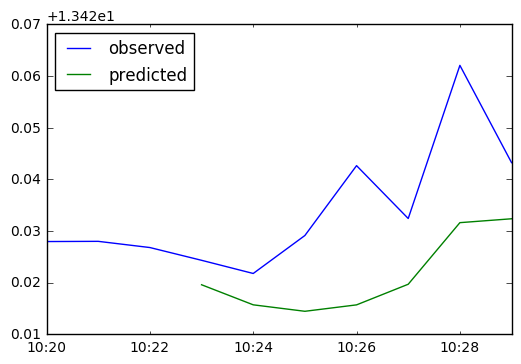

In [20]:
simulator.predictions['Open_Ask_USDMXN'][0].df.plot()